In [2]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [3]:
using CSV
using DataFrames
using Distributions
using HTTP
import ForneyLab.dot2svg
@everywhere using Mamba
# using Mamba
using Plots

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl


# 1 ベイズ推論の考え方
## 1.4 例題 : メッセージ数に変化はあるのか？
メッセージ受信数が時間が経つにつれて変化するかどうかを調べる

In [4]:
r = HTTP.request("GET", "https://git.io/vXTVC");
count_data = CSV.read(IOBuffer(r.body), header=["messages"])
disallowmissing!(count_data)

,messages
,Float64
1,13.0
2,24.0
3,8.0
4,24.0
5,7.0
6,35.0
7,14.0
8,11.0
9,15.0


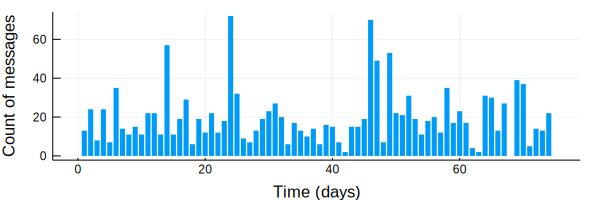

In [5]:
bar(count_data.messages, label = "", size = [600, 200],
    linecolor = :transparent,
    xlabel = "Time (days)", ylabel = "Count of messages")

$i$日目のメッセージを$C_i$とするとき、
\begin{align}
C_i \sim \text{Poisson}(\lambda)
\end{align}
とする.
### まずは一番な単純なモデル
\begin{align}
\lambda \sim \text{Exp}(\alpha)
\end{align}
のモデルを作ってみる。$\alpha$は計数データの平均の逆数とする。Distribution.jlにおけるパラメーターの取り方は、PyMCと異なることに留意。  
https://juliastats.github.io/Distributions.jl/latest/univariate.html#Continuous-Distributions-1

In [53]:
theta = mean(count_data.messages)

19.743243243243242

In [79]:
model0 = Model(
    
    obs = Stochastic(1,
        (ls, N) ->
            UnivariateDistribution[Poisson(ls[i]) for i in 1:N],
        false
    ),
    
    ls = Logical(1, (lambda, N) -> fill(lambda, N), false),
    
    lambda = Stochastic(theta -> Exponential(theta)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
ls:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]


In [80]:
data0 = Dict{Symbol, Any}(
    :obs => count_data.messages,
    :theta => theta,
    :N => length(count_data.messages),
)

Dict{Symbol,Any} with 3 entries:
  :N     => 74
  :obs   => [13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0,…
  :theta => 19.7432

In [81]:
inits0 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda => 1 / alpha,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])

In [82]:
scheme0 = [AMWG([:lambda], 1.0)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [83]:
setsamplers!(model0, scheme0)
sim0 = mcmc(model0, data0, inits0, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 3:	Chain 2:   0% [0:00:45 of 0:00:45 remaining]
      From worker 2:	Chain 3:   0% [0:00:45 of 0:00:45 remaining]
      From worker 4:	Chain 1:   0% [0:00:27 of 0:00:27 remaining]
      From worker 3:	Chain 2:  10% [0:00:04 of 0:00:04 remaining]
      From worker 4:	Chain 1:  10% [0:00:04 of 0:00:05 remaining]
      From worker 2:	Chain 3:  10% [0:00:04 of 0:00:05 remaining]
      From worker 3:	Chain 2:  20% [0:00:03 of 0:00:04 remaining]
      From worker 4:	Chain 1:  20% [0:00:04 of 0:00:05 remaining]
      From worker 2:	Chain 3:  20% [0:00:04 of 0:00:05 remaining]
      From worker 3:	Chain 2:  30% [0:00:03 of 0:00:05 remaining]
      From worker 4:	Chain 1:  30% [0:00:03 of 0:00:05 remaining]
      From worker 2:	Chain 3:  30% [0:00:04 of 0:00:05 remaining]
      From worker 3:	Chain 2:  40% [0:00:03 of 0:00:05 remaining]
      From worker 4:	Chain 1:  40% [0:00:03 of 0:00:05 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[19.0091; 19.637; … ; 19.1839; 19.3137]

[20.1912; 20.1912; … ; 19.858; 19.4884]

[20.3072; 20.1866; … ; 19.4109; 20.3935]

$\lambda$の平均はメッセージ数の平均とほぼ一致。

In [84]:
describe(sim0)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
          Mean       SD      Naive SE      MCSE     ESS
lambda 19.749008 0.5084814 0.005359864 0.007852254 3000

Quantiles:
          2.5%     25.0%    50.0%    75.0%    97.5%  
lambda 18.738235 19.40396 19.74414 20.08331 20.760313



In [85]:
gelmandiag(sim0, mpsrf = true, transform = true)

             PSRF 97.5%
      lambda    1     1
Multivariate    1   NaN



サンプリングの図示。サイズの変え方がわからない・・・

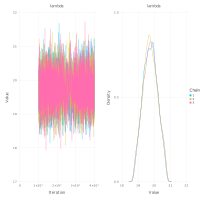

In [86]:
p0 = Mamba.plot(sim0, legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

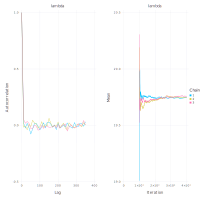

In [87]:
p0 = Mamba.plot(sim0, [:autocor, :mean], legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

### 変化はあるか？
ここで、どこかで$\lambda$が大きくなっているか調べるために、
\begin{align}
\lambda = \left\{ \begin{array}{ll}
\lambda_1 & \text{if}\ t < \tau,\\
\lambda_2 & \text{if}\ t \ge \tau. 
\end{array} \right.
\end{align}
となっていると仮定する。
事前分布は、
\begin{align}
\lambda_1 & \sim \text{Exp}(\alpha) \\
\lambda_2 & \sim \text{Exp}(\alpha) \\
\tau & \sim \text{DiscreteUniform}(1,N)
\end{align}
とする。

In [98]:
model1 = Model(
    
    obs = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1, 
        (lambda1, lambda2, N) -> 
            (out = fill(lambda1, N);
            out[45:end, :] .= lambda2;
            out),
        false),
    
    lambda1 = Stochastic(theta -> Exponential(theta)),
    lambda2 = Stochastic(theta -> Exponential(theta)),
    
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
lambda2:
A monitored node of type "ScalarStochastic"
NaN


In [99]:
inits1 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda1 => theta,
        :lambda2 => theta,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda2=>19.7432)

In [100]:
scheme1 = [AMWG([:lambda1, :lambda2], 1.0)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda1, :lambda2]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [101]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data0, inits1, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 2:	Chain 3:   0% [0:01:53 of 0:01:53 remaining]
      From worker 4:	Chain 2:   0% [0:01:57 of 0:01:58 remaining]
      From worker 3:	Chain 1:   0% [0:02:17 of 0:02:17 remaining]
      From worker 3:	Chain 1:  10% [0:00:06 of 0:00:07 remaining]
      From worker 2:	Chain 3:  10% [0:00:06 of 0:00:07 remaining]
      From worker 4:	Chain 2:  10% [0:00:06 of 0:00:07 remaining]
      From worker 3:	Chain 1:  20% [0:00:06 of 0:00:07 remaining]
      From worker 4:	Chain 2:  20% [0:00:06 of 0:00:07 remaining]
      From worker 2:	Chain 3:  20% [0:00:06 of 0:00:07 remaining]
      From worker 2:	Chain 3:  30% [0:00:05 of 0:00:07 remaining]
      From worker 3:	Chain 1:  30% [0:00:05 of 0:00:07 remaining]
      From worker 4:	Chain 2:  30% [0:00:05 of 0:00:07 remaining]
      From worker 2:	Chain 3:  40% [0:00:04 of 0:00:07 remaining]
      From worker 3:	Chain 1:  40% [0:00:04 of 0:00:07 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[22.5806 16.6466; 22.3985 16.8096; … ; 21.4489 18.7767; 21.9076 17.7793]

[21.4411 17.4501; 24.0317 18.1631; … ; 21.3806 17.3512; 23.6898 17.5224]

[23.4406 18.7725; 23.3116 17.7551; … ; 22.1521 17.7409; 22.1521 17.7409]

In [102]:
describe(sim1)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
           Mean       SD      Naive SE      MCSE     ESS
lambda2 22.692010 0.8774126 0.009248741 0.013563643 3000
lambda1 17.727691 0.6332428 0.006674965 0.008957439 3000

Quantiles:
           2.5%     25.0%     50.0%     75.0%     97.5% 
lambda2 20.964098 22.094653 22.677287 23.289439 24.42187
lambda1 16.498376 17.300869 17.726336 18.141317 19.00142



In [103]:
gelmandiag(sim1, mpsrf = true, transform = true)

             PSRF 97.5%
     lambda2    1 1.001
     lambda1    1 1.000
Multivariate    1   NaN



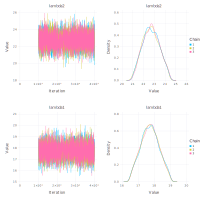

In [104]:
p1 = Mamba.plot(sim1, legend = true)
Mamba.draw(p1[:, 1:2], nrow = 2, ncol = 2)

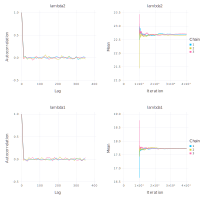

In [105]:
p1 = Mamba.plot(sim1, [:autocor, :mean], legend = true)
Mamba.draw(p1[:, 1:2], nrow = 2, ncol = 2)